# Training simple model and evalualing its predictions on different tasks

## Prepare dataset for training

First let's load splitted dataset generated in [another notebook](https://github.com/tinyclues/recsys-multi-atrribute-benchmark/blob/master/dataset_preprocessing/movielens%20with%20imdb.ipynb)

In [1]:
DATASET = 'movielens_imdb'

In [2]:
import os
import tensorflow as tf

from utils import DATASETS_ROOT_DIR

datasets = {}
for split_name in ['train', 'val', 'test']:
    path = os.path.join(DATASETS_ROOT_DIR, f'{DATASET}/aggregated_{split_name}_dataset.tf')
    datasets[split_name] = tf.data.experimental.load(path, compression="GZIP")

2023-02-22 19:32:36.009244: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 19:32:38.923662: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2023-02-22 19:32:38.923716: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-22 19:32:46.971463: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


2023-02-22 19:32:53.821339: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2023-02-22 19:32:53.821397: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-22 19:32:53.821441: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (6c9ae5c9a3d2): /proc/driver/nvidia/version does not exist
2023-02-22 19:32:53.823109: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other 

We can parse features' names, they were chosen to easily distinguish between offer features (that will be used to modelize film) and user features (aggregated history up to chosen date).

In [3]:
from utils import AGG_PREFIX

all_columns = list(datasets['train'].element_spec.keys())
technical_columns = ['userId', 'date']
user_features = list(filter(lambda x: x.startswith(AGG_PREFIX), all_columns))
offer_features = list(filter(lambda x: x not in user_features + technical_columns, all_columns))

In [4]:
user_features

['aggregated_ratings_imdbId',
 'aggregated_ratings_runtimeMinutesCluster',
 'aggregated_ratings_director',
 'aggregated_ratings_actor',
 'aggregated_ratings_titleType',
 'aggregated_ratings_startYearCluster',
 'aggregated_ratings_genre']

In [5]:
offer_features

['imdbId',
 'runtimeMinutesCluster',
 'startYearCluster',
 'titleType',
 'genre',
 'director',
 'actor']

### Rebatch dataset by events

First we will unnest events for each user (stored in second dimension of saved tensors) and keep only limited number of them. This operation will be needed further to avoid collisions during generation of negative examples. Then we will rebatch results into smaller batches (`50400` events for validation and test sets and `10080` events for train set).

In [6]:
%%time

from functools import partial
from uuid import uuid4

from utils import rebatch_by_events

datasets['train'] = rebatch_by_events(datasets['train'], batch_size=10080, date_column='date', nb_events_by_user_by_day=8)
for key in ['val', 'test']:
    datasets[key] = rebatch_by_events(datasets[key], batch_size=50400, date_column='date', nb_events_by_user_by_day=8,
                                      seed=1729).cache(f'/tmp/{uuid4()}.tf')

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
CPU times: user 42.2 s, sys: 6.93 s, total: 49.1 s
Wall time: 39.1 s


In [7]:
train_batch, y = next(iter(datasets['train']))
train_batch['imdbId'].shape[0]  # check batch size

10080

## Define simple model

Let's now define a simple model we want to test. Independetly from model's choice we need to embed inputs in some vectorial space. To define such embeddings we need number of different modalities inputs can take, and we can get this information from saved vectorizers:

In [8]:
from utils import load_inverse_lookups
inverse_lookups = load_inverse_lookups(os.path.join(DATASETS_ROOT_DIR, f'{DATASET}/inverse_lookups.pickle'))

In [9]:
import re

vocabulary_sizes = {}

for feature in offer_features:
    vocabulary_sizes[feature] = inverse_lookups[feature].vocabulary_size()

for feature in user_features:
    for key in inverse_lookups:
        pattern = re.compile(r"{}(\w+)_{}".format(AGG_PREFIX, key))
        if pattern.match(feature):
            vocabulary_sizes[feature] = vocabulary_sizes[key]

Now `vocabulary_sizes` contains modality of each feature

In [10]:
vocabulary_sizes

{'imdbId': 7894,
 'runtimeMinutesCluster': 35,
 'startYearCluster': 40,
 'titleType': 20,
 'genre': 36,
 'director': 3104,
 'actor': 2507,
 'aggregated_ratings_imdbId': 7894,
 'aggregated_ratings_runtimeMinutesCluster': 35,
 'aggregated_ratings_director': 3104,
 'aggregated_ratings_actor': 2507,
 'aggregated_ratings_titleType': 20,
 'aggregated_ratings_startYearCluster': 40,
 'aggregated_ratings_genre': 36}

### Model architecture

For the benchmarks we want to do, model's architecture doesn't play a crucial role, we saw the same problems in any model that averages embeddings of offer features in a naive way. So let's take some simple model's architecture, for example collaborative filtering using two towers neural network:

<img src="resources/two_towers_model.png" alt="two tower model" width="800" />

### Model parameters

To choose model's parameters we did some manual tuning using validation set to maximize train and test AUC while keeping mismatch between them small.

In [11]:
# model parameters
EMBEDDING_DIM = 50
L1_COEFF = 1e-8
DROPOUT = 0.05


def REGULARIZER():
    return {'class_name': 'L1L2', 'config': {'l1': L1_COEFF, 'l2': 0.}}

def USER_TOWER():
    return tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(70,
                              kernel_regularizer=REGULARIZER(),
                              bias_regularizer=REGULARIZER()),
        tf.keras.layers.Dropout(DROPOUT),
        tf.keras.layers.Activation('tanh'),
    ], name='user_tower')

def OFFER_TOWER():
    return tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(70,
                              kernel_regularizer=REGULARIZER(),
                              bias_regularizer=REGULARIZER()),
        tf.keras.layers.Dropout(DROPOUT),
        tf.keras.layers.Activation('tanh'),
    ], name='offer_tower')

EPOCHS = 3

NUMBER_OF_NEGATIVES = 4
LOSS = tf.keras.losses.BinaryCrossentropy(from_logits=True)
AUC_METRIC = tf.keras.metrics.AUC(from_logits=True)

import tensorflow_addons as tfa
OPTIMIZER = tfa.optimizers.AdamW(weight_decay=1e-8, learning_rate=0.002)

### Embeddings

Let's embed all available `user_features` and `offer_features` into vectorial space of dimension `EMBEDDING_DIM`. We use custom embeddings layer class `WeightedEmbeddings` that will automatically take a mean embedding vector when needed.

In particular,
* `user_features` are lists of attributes and we don't need to take into account any weights.
* `offer_features` during the inference can contain lists of attributes because of aggregation. We will also pass weights explicitly during the inference
* `offer_features` during training are lists with only one element, so we need to define dummy weights for training

All three cases can be treated by the same layer, where we will define a sparse matrix of all attributes we want to embed and then multiply it by the dense matrix with embeddings, multiplying by weights at the same time (if needed).

In [12]:
from utils import add_equal_weights

for key in datasets:
    datasets[key] = datasets[key].map(partial(add_equal_weights, features=offer_features))
train_batch, y = next(iter(datasets['train']))

In [13]:
# dummy weights needed for training
train_batch['genre_weight'][:5]

<tf.RaggedTensor [[1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0]]>

In [14]:
# embeddings layer example
from layers import WeightedEmbeddings
example_layer = WeightedEmbeddings(3, 5, name='test')
example_layer(tf.ragged.constant([[0], [1], [0, 1]]))

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[ 0.00327439,  0.00219459, -0.04844108,  0.0130989 ,  0.00037873],
       [ 0.04685669,  0.0310922 , -0.01893373, -0.00201491, -0.03844487],
       [ 0.02506554,  0.0166434 , -0.0336874 ,  0.00554199, -0.01903307]],
      dtype=float32)>

Now we can define all embeddings layers:

In [15]:
from layers import get_input_layer, WeightedEmbeddings
from utils import WEIGHT_SUFFIX

embeddings, inputs = {}, {}
for feature in user_features + offer_features:
    if feature in offer_features:
        # for offer features we need weights:
        # with dummy weights during training, and the ones used for a feature's averaging at inference time
        inputs[f'{feature}{WEIGHT_SUFFIX}'] = get_input_layer(f'{feature}{WEIGHT_SUFFIX}', tf.float32)
    inputs[feature] = get_input_layer(feature)
    # here we use input feature modality from `vocabulary_sizes` to know embeddings matrix dimensions
    emb_layer = WeightedEmbeddings(vocabulary_sizes[feature],
                                   EMBEDDING_DIM, name=f'{feature}_embedding',
                                   embeddings_regularizer=REGULARIZER())
    embeddings[feature] = emb_layer(inputs[feature], inputs.get(f'{feature}{WEIGHT_SUFFIX}'))

In [16]:
embeddings

{'aggregated_ratings_imdbId': <KerasTensor: shape=(None, 50) dtype=float32 (created by layer 'aggregated_ratings_imdbId_embedding')>,
 'aggregated_ratings_runtimeMinutesCluster': <KerasTensor: shape=(None, 50) dtype=float32 (created by layer 'aggregated_ratings_runtimeMinutesCluster_embedding')>,
 'aggregated_ratings_director': <KerasTensor: shape=(None, 50) dtype=float32 (created by layer 'aggregated_ratings_director_embedding')>,
 'aggregated_ratings_actor': <KerasTensor: shape=(None, 50) dtype=float32 (created by layer 'aggregated_ratings_actor_embedding')>,
 'aggregated_ratings_titleType': <KerasTensor: shape=(None, 50) dtype=float32 (created by layer 'aggregated_ratings_titleType_embedding')>,
 'aggregated_ratings_startYearCluster': <KerasTensor: shape=(None, 50) dtype=float32 (created by layer 'aggregated_ratings_startYearCluster_embedding')>,
 'aggregated_ratings_genre': <KerasTensor: shape=(None, 50) dtype=float32 (created by layer 'aggregated_ratings_genre_embedding')>,
 'imdb

### Combining everything into model

Now we can define described model architecture on the top of embeddings.

In [17]:
embedded_user_features = [embeddings[feature] for feature in user_features]
embedded_offer_features = [embeddings[feature] for feature in offer_features]
user_tower = USER_TOWER()(tf.keras.layers.Concatenate(name='concat_user')(embedded_user_features))
offer_tower = OFFER_TOWER()(tf.keras.layers.Concatenate(name='concat_offer')(embedded_offer_features))

### Negative generation in mini-batches

As our dataset contains only positive examples, up to this point we used only them. We have different choices of how to choose negative examples, but we chose most optimal one for calculations (both in memory and time) - we will generate negatives at the same time as calculating interactions between user and offer embeddings, proceding in minibatches:
* let's fix a number `N - 1` of how many negative examples we want to generate for each positive one
* consider minibatches of size `N` with events done on the same (or close) date (this was ensured by batch construction above)
* inside each minibatch we have users `u1, u2, ..., uN` who rated films `f1, f2, ..., fN` respectively on the same date `d`
* let's consider all possible pairs `(u1, f1), (u1, f2), ..., (uN, fN)` (`N ** 2` pairs in total)
* among those pairs there are `N` positive examples, all other `N(N - 1)` pairs are considered as negative ones
* it gives us exactly `N - 1` negative examples for each from `N` positive ones

We pair this process with interaction calculation by calculating not only scalar products between positive pairs, but between all `N ** 2` pairs per minibatch. Such operation can be written as multiplication of tensors, keeping number of embeddings calculations fixed (`2 * N` for each minibatch).

In [18]:
class DotWithNegatives(tf.keras.layers.Layer):
    def __init__(self, number_of_negatives, **kwargs):
        super().__init__(**kwargs)
        self.number_of_negatives = number_of_negatives
        
    def call(self, inputs, generate_negatives):
        user_embeddings, offer_embeddings = inputs
        if generate_negatives:
            # here we will generate negative examples inside mini-batches
            batch_size = tf.shape(user_embeddings)[0]
            # we split original batch into mini-batches of size (number_of_negatives + 1)
            minibatch_shape = (batch_size // (self.number_of_negatives + 1), (self.number_of_negatives + 1), -1)
            user_embeddings = tf.reshape(user_embeddings, minibatch_shape)
            offer_embeddings = tf.reshape(offer_embeddings, minibatch_shape)
            # for each pair of lines i,j inside minibatch, we consider pairs user/offer
            # * as positive examples when i==j
            # * as negative examples otherwise
            # at the end we flatten mini-batch dimension and obtain batch_size * (number_of_negatives + 1) predictions
            res = tf.einsum('bid,bjd->bij', user_embeddings, offer_embeddings)
        else:
            # otherwise we do just scalar product, let's write it in einsum notation too to see a difference between two
            res = tf.einsum('bd,bd->b', user_embeddings, offer_embeddings)
        return tf.reshape(res, (-1, 1))

In [19]:
# we don't apply sigmoid on the output and will have from_logits=True in both loss and metrics
output = DotWithNegatives(NUMBER_OF_NEGATIVES, name='prediction')([user_tower, offer_tower], generate_negatives=True)

In [20]:
output

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'prediction')>

Now our labels from batch are not aligned with output we produce, to get positive/negative labels at needed positions we just need to find which index would correspond to which label when considering a minibatch. This logic is implemented in auxilary classes `BroadcastLoss` and `BroadcastMetric`.

In [21]:
from utils import BroadcastLoss, BroadcastMetric

model = tf.keras.Model(inputs, output, name='two_tower_model')
model.compile(optimizer=OPTIMIZER,
              loss=BroadcastLoss(LOSS, NUMBER_OF_NEGATIVES),
              metrics=[BroadcastMetric(AUC_METRIC, NUMBER_OF_NEGATIVES)])

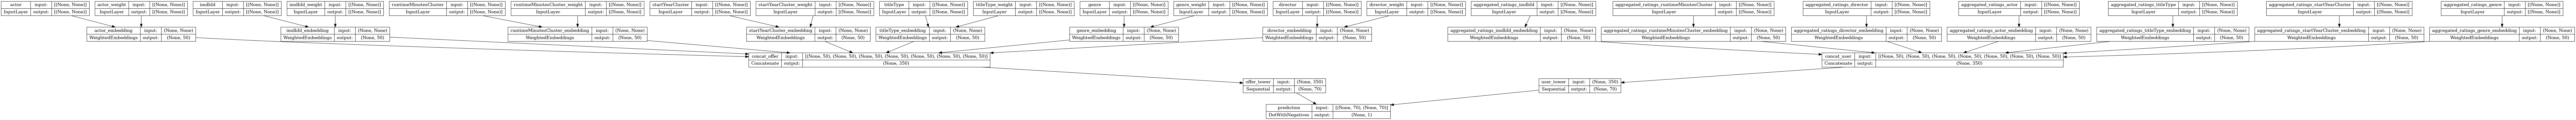

In [22]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file=f'models/{DATASET}_simple_model.png')

### Training

In [23]:
# TODO something wrong AUC stays at 0.5
model.fit(datasets['train'], epochs=EPOCHS, validation_data=datasets['val'])

Epoch 1/3


/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['userId', 'date'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


    231/Unknown - 105s 302ms/step - loss: 0.5001 - auc: 0.6129

2023-02-22 19:36:11.338404: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


231/231 [==============================] - 127s 398ms/step - loss: 0.5001 - auc: 0.6129 - val_loss: 0.5245 - val_auc: 0.5342


2023-02-22 19:36:31.159859: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 2/3
231/231 [==============================] - 76s 306ms/step - loss: 0.4722 - auc: 0.6637 - val_loss: 0.5076 - val_auc: 0.6092
Epoch 3/3
231/231 [==============================] - 80s 321ms/step - loss: 0.4689 - auc: 0.6718 - val_loss: 0.4848 - val_auc: 0.6417


## Single task models benchmark (In progress)

As described in (TODO link to article) we can consider predictions on one chosen offer column as a single task and the whole setup as a multi-task problem. Let's now evaluate performance of a common model on a subset of tasks. We will compare its results against single task models sharing the same architecture, but using only one offer feature at time.

In [24]:
# offer columns we want to evaluate, specific to dataset we test
TASKS = ['imdbId', 'directors', 'genres']

For simplicity of further code, let's wrap whole model definition into a function:

In [25]:
def two_tower_model(offer_features, name='two_tower_model'):
    # user_features, vocabulary_sizes, EMBEDDING_DIM, REGULARIZER, USER_TOWER, OFFER_TOWER,
    # OPTIMIZER, LOSS, NUMBER_OF_NEGATIVES
    # come from global scope, but can be passed as params instead
    embeddings, inputs = {}, {}
    for feature in user_features + offer_features:
        if feature in offer_features:
            # for offer features we need weights:
            # with dummy weights during training, and the ones used for a feature's averaging at inference time
            inputs[f'{feature}{WEIGHT_SUFFIX}'] = get_input_layer(f'{feature}{WEIGHT_SUFFIX}', tf.float32)
        inputs[feature] = get_input_layer(feature)
        # here we use input feature modality from `vocabulary_sizes` to know embeddings matrix dimensions
        emb_layer = WeightedEmbeddings(vocabulary_sizes[feature],
                                       EMBEDDING_DIM, name=f'{feature}_embedding',
                                       embeddings_regularizer=REGULARIZER())
        embeddings[feature] = emb_layer(inputs[feature], inputs.get(f'{feature}{WEIGHT_SUFFIX}'))
    
    embedded_user_features = [embeddings[feature] for feature in user_features]
    embedded_offer_features = [embeddings[feature] for feature in offer_features]
    user_tower = USER_TOWER()(tf.keras.layers.Concatenate(name='concat_user')(embedded_user_features))
    offer_tower = OFFER_TOWER()(tf.keras.layers.Concatenate(name='concat_offer')(embedded_offer_features))
    
    output = DotWithNegatives(NUMBER_OF_NEGATIVES, name='prediction')([user_tower, offer_tower], generate_negatives=True)
    model = tf.keras.Model(inputs, output, name=name)
    model.compile(optimizer=OPTIMIZER,
                  loss=BroadcastLoss(LOSS, NUMBER_OF_NEGATIVES),
                  metrics=[BroadcastMetric(AUC_METRIC, NUMBER_OF_NEGATIVES)])
    
    return model